In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio

In [2]:
import torch
from collections import OrderedDict
from torch.autograd import Variable
import itertools
# import util.util as util
# from util.image_pool import ImagePool
# from .base_model import BaseModel
# from . import networks
# import pytorch modules
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init
import functools
from torch.optim import lr_scheduler
import torch.utils.data

In [3]:
# find gpu
cuda = torch.cuda.is_available()

In [4]:
# hyperparameters
class Options():
    def __init__(self):
        self.isTrain = True
        self.checkpoints_dir = 'checkpoints'
        self.beta1 = 0.5
        self.pool_size = 50
        self.lambda_A = 10.
        self.lambda_B = 10.
        self.lambda_identity = 0
        
opt = Options()

In [5]:
import os
import torch


class BaseModel():
    def name(self):
        return 'BaseModel'

    def initialize(self, opt):
        self.opt = opt
        self.isTrain = opt.isTrain
        self.Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor
        self.save_dir = opt.checkpoints_dir

    def set_input(self, input):
        self.input = input

    def forward(self):
        pass

    # used in test time, no backprop
    def test(self):
        pass

    def get_image_paths(self):
        pass

    def optimize_parameters(self):
        pass

    def get_current_visuals(self):
        return self.input

    def get_current_errors(self):
        return {}

    def save(self, label):
        pass

    # helper saving function that can be used by subclasses
    def save_network(self, network, network_label, epoch_label):
        save_filename = '%s_net_%s.pth' % (epoch_label, network_label)
        save_path = os.path.join(self.save_dir, save_filename)
        torch.save(network.state_dict(), save_path)

    # helper loading function that can be used by subclasses
    def load_network(self, network, network_label, epoch_label):
        save_filename = '%s_net_%s.pth' % (epoch_label, network_label)
        save_path = os.path.join(self.save_dir, save_filename)
        network.load_state_dict(torch.load(save_path))

    # update learning rate (called once every epoch)
    def update_learning_rate(self):
        for scheduler in self.schedulers:
            scheduler.step()
        lr = self.optimizers[0].param_groups[0]['lr']
        print('learning rate = %.7f' % lr)

In [6]:
def tensor2im(image_tensor, imtype=np.uint8):
    image_numpy = image_tensor[0].cpu().float().numpy()
    if image_numpy.shape[0] == 1:
        image_numpy = np.tile(image_numpy, (3, 1, 1))
    image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0
    return image_numpy.astype(imtype)

In [7]:
class GANLoss(nn.Module):
    def __init__(self, target_real_label=1.0, target_fake_label=0.0,
                 tensor=torch.FloatTensor):
        super(GANLoss, self).__init__()
        self.real_label = target_real_label
        self.fake_label = target_fake_label
        self.Tensor = tensor
        if cuda:
            self.Tensor = torch.cuda.FloatTensor
        self.loss = nn.BCELoss()
#         if use_lsgan:
#             self.loss = nn.MSELoss()
#         else:
#             self.loss = nn.BCELoss()

    def get_target_tensor(self, input, target_is_real):
        target_tensor = None
        if target_is_real:
            real_tensor = self.Tensor(input.size()).fill_(self.real_label)
            self.real_label_var = Variable(real_tensor, requires_grad=False)
            target_tensor = self.real_label_var
        else:
            fake_tensor = self.Tensor(input.size()).fill_(self.fake_label)
            self.fake_label_var = Variable(fake_tensor, requires_grad=False)
            target_tensor = self.fake_label_var
        return target_tensor

    def __call__(self, input, target_is_real):
        target_tensor = self.get_target_tensor(input, target_is_real)
        return self.loss(input, target_tensor)

In [8]:
class ImagePool():
    def __init__(self, pool_size):
        self.pool_size = pool_size
        if self.pool_size > 0:
            self.num_imgs = 0
            self.images = []

    def query(self, images):
        if self.pool_size == 0:
            return Variable(images)
        return_images = []
        for image in images:
            image = torch.unsqueeze(image, 0)
            if self.num_imgs < self.pool_size:
                self.num_imgs = self.num_imgs + 1
                self.images.append(image)
                return_images.append(image)
            else:
                p = np.random.uniform(0, 1)
                if p > 0.5:
                    random_id = np.random.randint(0, self.pool_size - 1)
                    tmp = self.images[random_id].clone()
                    self.images[random_id] = image
                    return_images.append(tmp)
                else:
                    return_images.append(image)
        return_images = Variable(torch.cat(return_images, 0))
        return return_images

In [9]:
class Decoder3d(nn.Module):
    def __init__(self):
        super(Decoder3d, self).__init__()
        
        # hyperparameters
        self.z_size = 200
        self.cube_len = 32
        self.bias = True

        padd = (0, 0, 0)

        self.layer1 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.z_size, self.cube_len*4, kernel_size=4, stride=2,\
                                     bias=self.bias, padding=padd),
            torch.nn.BatchNorm3d(self.cube_len*4),
            torch.nn.ReLU()
        )
        self.layer2 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_len*4, self.cube_len*2, kernel_size=4, stride=2, bias=self.bias,\
                                     padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_len*2),
            torch.nn.ReLU()
        )
        self.layer3 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_len*2, self.cube_len*1, kernel_size=4, stride=2, bias=self.bias,\
                                     padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_len*1),
            torch.nn.ReLU()
        )

        self.layer4 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_len, 1, kernel_size=4, stride=2, bias=self.bias, padding=(1, 1, 1)),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        out = x.unsqueeze(-1)
        out = self.layer1(out)
        out = self.layer2(out)
#         print(out.size())
        out = self.layer3(out)
#         print(out.size())
        out = self.layer4(out)

        return out


In [10]:
class Encoder3d(nn.Module):
    def __init__(self):
        super(Encoder3d, self).__init__()
        
        # hyperparameters
        self.z_size = 200
        self.cube_len = 32
        self.bias = True
        
        self.layer1 = nn.Sequential(
            nn.Conv3d(1, self.cube_len, kernel_size=4, stride=2, bias=self.bias, padding=(1, 1, 1)),
            nn.BatchNorm3d(self.cube_len*1),
            nn.ReLU()
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv3d(self.cube_len, self.cube_len*2, kernel_size=4, stride=2, bias=self.bias,\
                                     padding=(1, 1, 1)),
            nn.BatchNorm3d(self.cube_len*2),
            nn.ReLU()
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv3d(self.cube_len*2, self.cube_len*4, kernel_size=4, stride=2, bias=self.bias,\
                                     padding=(1, 1, 1)),
            nn.BatchNorm3d(self.cube_len*4),
            nn.ReLU()
        )
        
        self.layer4 = torch.nn.Sequential(
            nn.Conv3d(self.cube_len*4, self.z_size, kernel_size=4, stride=2,\
                                     bias=self.bias, padding=(0,0,0)),
            nn.Tanh()
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        return out

In [11]:
class Decoder2d(nn.Module):
    def __init__(self, input_nc=200, output_nc=1, ngf=8, norm_layer=nn.BatchNorm2d,\
                 use_dropout=False, padding_type='reflect'):
        super(Decoder2d, self).__init__()
        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

       

        model = []
        
        n_upsampling = 4
        mult = 2**(n_upsampling-1)
        
        model += [nn.ConvTranspose2d(input_nc, ngf * mult * 2, kernel_size=2,
                                    stride=1, padding=0, bias=use_bias),\
                                norm_layer(ngf * mult * 2),
                                nn.ReLU(True)]
        
        
        for i in range(2):
            model += [nn.ConvTranspose2d(ngf * mult * 2, ngf * mult * 2, kernel_size=3,
                                        stride=2, padding=1, bias=use_bias),
                              norm_layer(ngf * mult * 2),
                              nn.ReLU(True)]
            
        # padding to maintain output size
        p2d = (1, 1, 1, 1) 
        model += [nn.ZeroPad2d(p2d),]
        
        for i in range(n_upsampling):
            mult = 2**(n_upsampling-1-i)
            model += [nn.ConvTranspose2d(ngf * mult * 2, ngf * mult, kernel_size=5,
                                stride=2, padding=1, bias=use_bias),\
                      norm_layer(ngf * mult),
                      nn.ReLU(True)]
        
        # padding to maintain output size
        p2d = (0, 1, 0, 1) 
        model += [nn.ZeroPad2d(p2d),]
        
        model += [#nn.ReflectionPad2d(2),
                 nn.ConvTranspose2d(ngf, output_nc, kernel_size=5, padding=2,
                           bias=use_bias)]
        
#         self.model = nn.Sequential(*model)
        self.model = nn.ModuleList(model)
        
    def forward(self, x):
        out = x.squeeze(-1)
        for model in self.model:
            out = model(out)
#             print(out.size())
#         out = self.model(out)
        return out

In [12]:
class Encoder2d(nn.Module):
    def __init__(self, input_nc=1, output_nc=200, ngf=8, norm_layer=nn.BatchNorm2d,\
                 use_dropout=False, padding_type='reflect'):
        super(Encoder2d, self).__init__()
        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        model = [nn.ReflectionPad2d(2),
                 nn.Conv2d(input_nc, ngf, kernel_size=5, padding=0,
                           bias=use_bias),
                 norm_layer(ngf),
                 nn.ReLU(True)]
        
        
        n_downsampling = 4
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=5,
                                stride=2, padding=1, bias=use_bias),
                      norm_layer(ngf * mult * 2),
                      nn.ReLU(True)]
        
        for i in range(2):
            model += [nn.Conv2d(ngf * mult * 2, ngf * mult * 2, kernel_size=3,
                                    stride=2, padding=1, bias=use_bias),
                          norm_layer(ngf * mult * 2),
                          nn.ReLU(True)]
            
        model += [nn.Conv2d(ngf * mult * 2, output_nc, kernel_size=2,
                                    stride=1, padding=0, bias=use_bias)]
        model += [nn.Tanh()]
        
            
        

#         mult = 2**(n_downsampling-1)
#         for i in range(n_blocks):
#             model += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer,\
#                                   use_dropout=use_dropout, use_bias=use_bias)]
            
        self.model = nn.ModuleList(model)
#         self.model = nn.Sequential(*model)

    def forward(self, x):
        for model in self.model:
            x = model(x)
#             print(x.size())
        return x
        #return self.model(input)

In [13]:
# Conv3d: (in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
# input size (N,Cin,D,H,W) and output (N,Cout,Dout,Hout,Wout) 


class Discriminator3d(nn.Module):
    
    def __init__(self):
        super(Discriminator3d, self).__init__()
        self.cube_len = 32
        self.leak_value = 0.2
        self.bias = False

        padd = (0,0,0)
        if self.cube_len == 32:
            padd = (1,1,1)
            
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv3d(1, self.cube_len, kernel_size=4, stride=2, bias=self.bias, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_len),
            torch.nn.LeakyReLU(self.leak_value)
        )
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv3d(self.cube_len, self.cube_len*2, kernel_size=4, stride=2, bias=self.bias, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_len*2),
            torch.nn.LeakyReLU(self.leak_value)
        )
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv3d(self.cube_len*2, self.cube_len*4, kernel_size=4, stride=2, bias=self.bias, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_len*4),
            torch.nn.LeakyReLU(self.leak_value)
        )
        self.layer4 = torch.nn.Sequential(
            torch.nn.Conv3d(self.cube_len*4, self.cube_len*8, kernel_size=4, stride=2, bias=self.bias, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_len*8),
            torch.nn.LeakyReLU(self.leak_value)
        )
        self.layer5 = torch.nn.Sequential(
            torch.nn.Conv3d(self.cube_len*8, 1, kernel_size=4, stride=2, bias=self.bias, padding=padd),
            torch.nn.Sigmoid()
        )
        
    def forward(self, x):
        #print(x)
        out = x.view(-1, 1, self.cube_len, self.cube_len, self.cube_len)
#         print(out.size()) # torch.Size([100, 1, 32, 32, 32])
        out = self.layer1(out)
#         print(out.size())  # torch.Size([100, 32, 16, 16, 16])
        out = self.layer2(out)
#         print(out.size())  # torch.Size([100, 64, 8, 8, 8])
        out = self.layer3(out)
#         print(out.size())  # torch.Size([100, 128, 4, 4, 4])
        out = self.layer4(out)
#         print(out.size())  # torch.Size([100, 256, 2, 2, 2])
        out = self.layer5(out)
#         print(out.size())  # torch.Size([100, 1, 1, 1, 1])

        return out
        

In [14]:
#Images are 128*128 into batch * 1
class Discriminator2d(nn.Module):
    
    def __init__(self):
        super(Discriminator2d, self).__init__()
        self.image_len = 128
        self.leak_value = 0.2
        self.bias = False

        padd = (0,0,0)
        if self.image_len == 128:
            padd = (1,1)
            
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, self.image_len, kernel_size=4, stride=2, bias=self.bias, padding=(1, 1)),
            torch.nn.BatchNorm2d(self.image_len),
            torch.nn.LeakyReLU(self.leak_value)
        )
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(self.image_len, self.image_len*2, kernel_size=4, stride=4, bias=self.bias, padding=(1, 1)),
            torch.nn.BatchNorm2d(self.image_len*2),
            torch.nn.LeakyReLU(self.leak_value)
        )
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(self.image_len*2, self.image_len*4, kernel_size=4, stride=4, bias=self.bias, padding=(1, 1)),
            torch.nn.BatchNorm2d(self.image_len*4),
            torch.nn.LeakyReLU(self.leak_value)
        )
        self.layer4 = torch.nn.Sequential(
            torch.nn.Conv2d(self.image_len*4, self.image_len*8, kernel_size=4, stride=2, bias=self.bias, padding=(1, 1)),
            torch.nn.BatchNorm2d(self.image_len*8),
            torch.nn.LeakyReLU(self.leak_value)
        )
        self.layer5 = torch.nn.Sequential(
            torch.nn.Conv2d(self.image_len*8, 1, kernel_size=4, stride=2, bias=self.bias, padding=padd),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        #print(x)
        out = x.view(-1, 1, self.image_len, self.image_len)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
#         print(out.size())  # torch.Size([1, 1, 1, 1])

        return out

In [15]:
class CycleGANModel(BaseModel):
    def initialize(self, opt):
        BaseModel.initialize(self, opt)
        # load/define networks
        self.encoder2d = Encoder2d()
        self.decoder3d = Decoder3d()
        self.encoder3d = Encoder3d()
        self.decoder2d = Decoder2d()
            
        self.netG_A = nn.Sequential(self.encoder2d, self.decoder3d)
        self.netG_B = nn.Sequential(self.encoder3d, self.decoder2d)
        self.netD_A = Discriminator3d()
        self.netD_B = Discriminator2d()
        if cuda:
            self.netG_A.cuda()
            self.netG_B.cuda()
            self.netD_A.cuda()
            self.netD_B.cuda()
        
        # optimizers
        self.optimizer_G = torch.optim.Adam(itertools.chain(self.netG_A.parameters(), \
                                                            self.netG_B.parameters()),\
                                                lr=2E-4, betas=(opt.beta1, 0.999))
        self.optimizer_D_A = torch.optim.Adam(self.netD_A.parameters(), lr=2E-4, betas=(opt.beta1, 0.999))
        self.optimizer_D_B = torch.optim.Adam(self.netD_B.parameters(), lr=2E-4, betas=(opt.beta1, 0.999))
    
        
        # fake pools to train discrtiminators
        self.fake_A_pool = ImagePool(opt.pool_size)
        self.fake_B_pool = ImagePool(opt.pool_size)
        
        # define loss functions
        self.criterionGAN = GANLoss()
        self.criterionCycle = torch.nn.L1Loss()
        self.criterionIdt = torch.nn.L1Loss() # may be needed if done with supervision
        
    def set_input(self, input_A, input_B):
#         AtoB = self.opt.which_direction == 'AtoB'
#         input_A = input['A' if AtoB else 'B']
#         input_B = input['B' if AtoB else 'A']
        self.input_A = input_A
        self.input_B = input_B
#         self.image_paths = input['A_paths' if AtoB else 'B_paths']

    def forward(self):
        self.real_A = Variable(self.input_A)
        self.real_B = Variable(self.input_B)

    def test(self):
        real_A = Variable(self.input_A, volatile=True)
        fake_B = self.netG_A(real_A)
        self.rec_A = self.netG_B(fake_B).data
        self.fake_B = fake_B.data

        real_B = Variable(self.input_B, volatile=True)
        fake_A = self.netG_B(real_B)
        self.rec_B = self.netG_A(fake_A).data
        self.fake_A = fake_A.data
       
        
    def backward_D_basic(self, netD, real, fake):
        # Real
        pred_real = netD(real)
        loss_D_real = self.criterionGAN(pred_real, True)
        # Fake
        pred_fake = netD(fake.detach())
        loss_D_fake = self.criterionGAN(pred_fake, False)
        # Combined loss
        loss_D = (loss_D_real + loss_D_fake) * 0.5
        # backward
        loss_D.backward()
        return loss_D

    def backward_D_A(self):
        fake_B = self.fake_B_pool.query(self.fake_B)
        loss_D_A = self.backward_D_basic(self.netD_A, self.real_B, fake_B)
        self.loss_D_A = loss_D_A.data[0]

    def backward_D_B(self):
        fake_A = self.fake_A_pool.query(self.fake_A)
        loss_D_B = self.backward_D_basic(self.netD_B, self.real_A, fake_A)
        self.loss_D_B = loss_D_B.data[0]

    def backward_G(self):
        lambda_idt = self.opt.lambda_identity
        lambda_A = self.opt.lambda_A
        lambda_B = self.opt.lambda_B
#         # Identity loss
        if lambda_idt > 0:
            # G_A should be identity if real_B is fed.
            idt_A = self.netG_A(self.real_B)
            loss_idt_A = self.criterionIdt(idt_A, self.real_B) * lambda_B * lambda_idt
            # G_B should be identity if real_A is fed.
            idt_B = self.netG_B(self.real_A)
            loss_idt_B = self.criterionIdt(idt_B, self.real_A) * lambda_A * lambda_idt

            self.idt_A = idt_A.data
            self.idt_B = idt_B.data
            self.loss_idt_A = loss_idt_A.data[0]
            self.loss_idt_B = loss_idt_B.data[0]
        else:
            loss_idt_A = 0
            loss_idt_B = 0
            self.loss_idt_A = 0
            self.loss_idt_B = 0

        # GAN loss D_A(G_A(A))
        fake_B = self.netG_A(self.real_A)
        pred_fake = self.netD_A(fake_B)
        loss_G_A = self.criterionGAN(pred_fake, True)

        # GAN loss D_B(G_B(B))
        fake_A = self.netG_B(self.real_B)
        pred_fake = self.netD_B(fake_A)
        loss_G_B = self.criterionGAN(pred_fake, True)

        # Forward cycle loss
        rec_A = self.netG_B(fake_B)
        loss_cycle_A = self.criterionCycle(rec_A, self.real_A) * lambda_A

        # Backward cycle loss
        rec_B = self.netG_A(fake_A)
        loss_cycle_B = self.criterionCycle(rec_B, self.real_B) * lambda_B
        # combined loss
        loss_G = loss_G_A + loss_G_B + loss_cycle_A + loss_cycle_B + loss_idt_A + loss_idt_B
        loss_G.backward()

        self.fake_B = fake_B.data
        self.fake_A = fake_A.data
        self.rec_A = rec_A.data
        self.rec_B = rec_B.data

        self.loss_G_A = loss_G_A.data[0]
        self.loss_G_B = loss_G_B.data[0]
        self.loss_cycle_A = loss_cycle_A.data[0]
        self.loss_cycle_B = loss_cycle_B.data[0]
        
    def optimize_parameters(self):
        # forward
        self.forward()
        # G_A and G_B
        self.optimizer_G.zero_grad()
        self.backward_G()
        self.optimizer_G.step()
        # D_A
        self.optimizer_D_A.zero_grad()
        self.backward_D_A()
        self.optimizer_D_A.step()
        # D_B
        self.optimizer_D_B.zero_grad()
        self.backward_D_B()
        self.optimizer_D_B.step()
        
    def get_current_errors(self):
        ret_errors = OrderedDict([('D_A', self.loss_D_A), ('G_A', self.loss_G_A), ('Cyc_A', self.loss_cycle_A),
                                  ('D_B', self.loss_D_B), ('G_B', self.loss_G_B), ('Cyc_B', self.loss_cycle_B)])
        if self.opt.lambda_identity > 0.0:
            ret_errors['idt_A'] = self.loss_idt_A
            ret_errors['idt_B'] = self.loss_idt_B
        return ret_errors

    def get_current_visuals(self):
#         real_A = tensor2im(self.input_A)
#         fake_B = tensor2im(self.fake_B)
#         rec_A = tensor2im(self.rec_A)
#         real_B = tensor2im(self.input_B)
#         fake_A = tensor2im(self.fake_A)
#         rec_B = tensor2im(self.rec_B)
#         ret_visuals = OrderedDict([('real_A', real_A), ('fake_B', fake_B), ('rec_A', rec_A),
#                                    ('real_B', real_B), ('fake_A', fake_A), ('rec_B', rec_B)])
#         if self.opt.isTrain and self.opt.lambda_identity > 0.0:
#             ret_visuals['idt_A'] = tensor2im(self.idt_A)
#             ret_visuals['idt_B'] = tensor2im(self.idt_B)
#         return ret_visuals

        return self.fake_A, self.fake_B

    def save(self, label):
        self.save_network(self.netG_A, 'G_A', label)
        self.save_network(self.netD_A, 'D_A', label)
        self.save_network(self.netG_B, 'G_B', label)
        self.save_network(self.netD_B, 'D_B', label)

In [16]:
# hyperparameters
bsize = 10

In [17]:
# load data
train_data = [np.load('voxels.npy'), np.load('padded_gray_images.npy')]
for _ in range(len(train_data)):
    train_data[_] =torch.from_numpy(train_data[_]).type(torch.FloatTensor)
    if cuda:
        train_data[_] = train_data[_].cuda()
train_data = [(train_data[0][i], train_data[1][i]) for i in range(len(train_data[0]))] 
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=bsize, shuffle=True, drop_last=True)

In [18]:
epochs = 20

In [19]:
model = CycleGANModel()
model.initialize(opt)

In [20]:
import time

for epoch in range(epochs):
    epoch_start_time = time.time()
    iter_data_time = time.time()
    epoch_iter = 0

    for batch_idx, (data3d, data2d) in enumerate(train_loader):
        data3d = data3d.unsqueeze(1)
        data2d = data2d.unsqueeze(1)
        model.set_input(data2d, data3d)
        model.optimize_parameters()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]'.format(
                epoch+1, batch_idx * len(train_loader), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                ))
            print(model.get_current_errors())
    print('saving the model at the end of epoch %d' %
          (epoch))
    model.save('latest')
    model.save(epoch)

    print('End of epoch %d\t Time Taken: %d sec' %
          (epoch, time.time() - epoch_start_time))

Train Epoch: 1 [0/4917 (0%)]
OrderedDict([('D_A', 0.6926053762435913), ('G_A', 0.7014886736869812), ('Cyc_A', 210.3956756591797), ('D_B', 0.7085673809051514), ('G_B', 0.6932010650634766), ('Cyc_B', 4.935762882232666)])
Train Epoch: 1 [49100/4917 (20%)]
OrderedDict([('D_A', 0.0056900400668382645), ('G_A', 5.1292877197265625), ('Cyc_A', 203.90631103515625), ('D_B', 0.03723207488656044), ('G_B', 2.9220938682556152), ('Cyc_B', 3.42930269241333)])
Train Epoch: 1 [98200/4917 (41%)]
OrderedDict([('D_A', 0.01855318620800972), ('G_A', 5.1011457443237305), ('Cyc_A', 198.0726318359375), ('D_B', 0.05493660271167755), ('G_B', 1.814361572265625), ('Cyc_B', 2.2816944122314453)])
Train Epoch: 1 [147300/4917 (61%)]
OrderedDict([('D_A', 0.019295409321784973), ('G_A', 5.38629674911499), ('Cyc_A', 181.3104248046875), ('D_B', 0.14763371646404266), ('G_B', 3.813861846923828), ('Cyc_B', 1.3883066177368164)])


KeyboardInterrupt: 

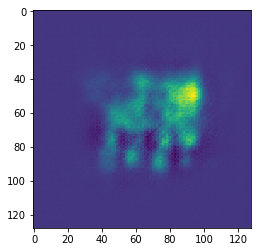

In [21]:
fake2d = model.get_current_visuals()[0][0].squeeze().cpu().numpy()
plt.imshow(fake2d)

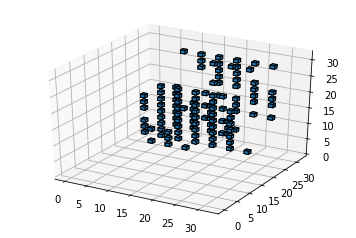

In [23]:
fake3d = model.get_current_visuals()[1][0].squeeze().cpu().numpy()>0.5

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(fake3d, edgecolor='k')

plt.show()